In [22]:
import pandas as pd

date_time = "06-12-2024_10-31-11"
df = pd.read_csv("./temp/aqi_"+date_time+".csv")

print(df)

          Sensor Name           X          Y  US AQI  source
0   Baltazar_Caloocan  120.977881  14.647996    12.0    WAQI
1              RENET1  121.068966  14.647362    23.0  UPCARE
2                UPD1  121.072000  14.647400    95.0  UPCARE
3                 PC1  121.069000  14.571700    94.0  UPCARE
4                 TC1  121.041000  14.535600    27.0  UPCARE
5                UPD2  121.071000  14.649800   106.0  UPCARE
6                 MC1  120.981000  14.592400   108.0  UPCARE
7              RENET3  121.062370  14.647500    19.0  UPCARE
8              RENET4  121.064530  14.660710    16.0  UPCARE
9             BAGUIO2  120.597128  16.410988    15.0  UPCARE
10            BAGUIO1  120.595146  16.413536    87.0  UPCARE
11             RENET5  121.073771  14.657549    16.0  UPCARE
12             RENET6  121.069258  14.657391    32.0  UPCARE
13             RENET2  121.071000  14.649800    61.0  UPCARE


In [32]:
# drop really far sensors
df = df.drop([9, 10])
print(df)

          Sensor Name           X          Y  US AQI  source
0   Baltazar_Caloocan  120.977881  14.647996    12.0    WAQI
1              RENET1  121.068966  14.647362    23.0  UPCARE
2                UPD1  121.072000  14.647400    95.0  UPCARE
3                 PC1  121.069000  14.571700    94.0  UPCARE
4                 TC1  121.041000  14.535600    27.0  UPCARE
5                UPD2  121.071000  14.649800   106.0  UPCARE
6                 MC1  120.981000  14.592400   108.0  UPCARE
7              RENET3  121.062370  14.647500    19.0  UPCARE
8              RENET4  121.064530  14.660710    16.0  UPCARE
11             RENET5  121.073771  14.657549    16.0  UPCARE
12             RENET6  121.069258  14.657391    32.0  UPCARE
13             RENET2  121.071000  14.649800    61.0  UPCARE


In [33]:
# import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

# import pykrige.kriging_tools as kt
# from pykrige.ok import OrdinaryKriging

data = df[["X","Y","US AQI"]].to_numpy()

gdf = gpd.read_file('./shapefiles/Philippines_Border.shp')

bounds = gdf.total_bounds
Xmin = bounds[0]
Ymin = bounds[1]
Xmax = bounds[2]
Ymax = bounds[3]

Xmin = min(df['X'])
Xmax = max(df['X'])
Ymin = min(df['Y'])
Ymax = max(df['Y'])

gridx = np.arange(Xmin, Xmax, 0.001)
gridy = np.arange(Ymin, Ymax, 0.001)

print(gridx)
print(gridy)

[120.97788066 120.97888066 120.97988066 120.98088066 120.98188066
 120.98288066 120.98388066 120.98488066 120.98588066 120.98688066
 120.98788066 120.98888066 120.98988066 120.99088066 120.99188066
 120.99288066 120.99388066 120.99488066 120.99588066 120.99688066
 120.99788066 120.99888066 120.99988066 121.00088066 121.00188066
 121.00288066 121.00388066 121.00488066 121.00588066 121.00688066
 121.00788066 121.00888066 121.00988066 121.01088066 121.01188066
 121.01288066 121.01388066 121.01488066 121.01588066 121.01688066
 121.01788066 121.01888066 121.01988066 121.02088066 121.02188066
 121.02288066 121.02388066 121.02488066 121.02588066 121.02688066
 121.02788066 121.02888066 121.02988066 121.03088066 121.03188066
 121.03288066 121.03388066 121.03488066 121.03588066 121.03688066
 121.03788066 121.03888066 121.03988066 121.04088066 121.04188066
 121.04288066 121.04388066 121.04488066 121.04588066 121.04688066
 121.04788066 121.04888066 121.04988066 121.05088066 121.05188066
 121.05288

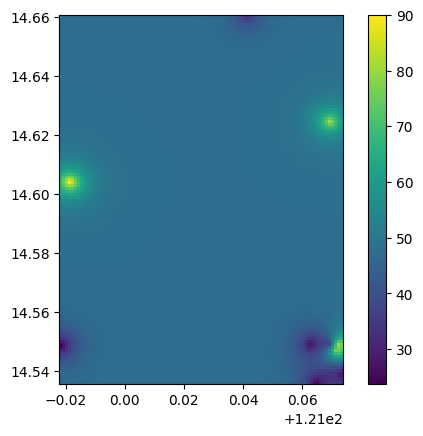

In [34]:
import matplotlib.pyplot as plt
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

OK = OrdinaryKriging(
    data[:, 0],
    data[:, 1],
    data[:, 2],
    variogram_model="exponential",
    nlags = 6,
    verbose=False,
    enable_plotting=False,
    exact_values=True,
    coordinates_type="geographic",
)

z_pred, ss = OK.execute("grid", gridx, gridy)

# kt.write_asc_grid(gridx, gridy, z, filename="output.asc")

fig, ax1 = plt.subplots()
pos = ax1.imshow(z_pred, interpolation='none', extent=[Xmin,Xmax,Ymin,Ymax])
fig.colorbar(pos, ax=ax1)
plt.show()

In [ ]:
import rasterio
from rasterio.transform import from_origin

output_raster_path="./shapefiles/Philippines_Pollution_"+date_time+".tif"
pixel_size = 0.001

transform = from_origin(gridx.min(), gridy.max(), pixel_size, pixel_size)

print(transform)

with rasterio.open(output_raster_path, 'w', driver='GTiff', 
            height=z_pred.shape[0], width=z_pred.shape[1],
            count=1, dtype=z_pred.dtype,
            crs='EPSG:4326', transform=transform) as dst:
    dst.write(z_pred, 1)

print(f"Raster file saved as: {output_raster_path}")

| 0.00, 0.00, 121.13|
| 0.00,-0.00, 14.35|
| 0.00, 0.00, 1.00|
Raster file saved as: ./shapefiles/Philippines_Pollution_06-12-2024_10-31-11.tif


In [8]:
import rasterio
from rasterio.transform import from_origin

# Define raster properties
date_time = "29-12-2023_21-46-49"
output_raster_path="./shapefiles/Philippines_Pollution_kriging.tif"
pixel_size = 0.001  # Resolution of the grid (adjust as necessary)

# Create the transform for the raster (affine transformation from pixel space to world coordinates)
transform = from_origin(gridx.min(), gridy.max(), pixel_size, pixel_size)

# Write the result to a GeoTIFF
with rasterio.open(output_raster_path, 'w', driver='GTiff', 
                   height=z.shape[0], width=z.shape[1],
                   count=1, dtype=z.dtype,
                   crs='EPSG:4326', transform=transform) as dst:
    dst.write(z, 1)

print(f"Raster file saved as: {output_raster_path}")

Raster file saved as: ./shapefiles/Philippines_Pollution_kriging.tif


In [ ]:
import rasterio
import geopandas as gpd
import pandas as pd

date_time = "29-12-2023_21-46-49"
input_point_shapefile="./shapefiles/Philippines_Pollution_"+date_time+".shp"
extent_shapefile="./shapefiles/Philippines_Border.shp"
blank_filename = extent_shapefile.rsplit('.', 1)[0] + '_blank.tif'
resized_raster_name = blank_filename.rsplit('.', 1)[0] + '_resized.tif'

with rasterio.open(resized_raster_name) as baseRasterFile:
    inputPoints = gpd.read_file(input_point_shapefile)
    # obser_df stands for observation_dataframe, lat, lon, data_value for each station will be stored here.
    obser_df = pd.DataFrame()
    obser_df['station_name'] = inputPoints.iloc[:, 0]

    # create two list of indexes of station longitude, latitude in elevation raster file.
    lons, lats = baseRasterFile.index(
        [lon for lon in inputPoints.geometry.x],
        [lat for lat in inputPoints.geometry.y])
    obser_df['lon_index'] = lons
    obser_df['lat_index'] = lats
    obser_df['data_value'] = inputPoints['US AQI']

In [ ]:
pip show fiona

Name: fiona
Version: 1.9.5
Summary: Fiona reads and writes spatial data files
Home-page: 
Author: Sean Gillies
Author-email: 
License: BSD 3-Clause
Location: c:\Users\Smart I-Lab 2\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: attrs, certifi, click, click-plugins, cligj, setuptools, six
Required-by: geopandas
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\smart i-lab 2\appdata\local\programs\python\python312\lib\site-packages\eventsource-1.2-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
